# Funkcie, include atd.

## Includes

In [3]:
pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=ab4e073b4775eaade99bc21138127256e0e79d76c0c1fa8c6be87d2cf0d5a9e5
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [4]:
import gensim
import nltk
import pandas as pd
import re
import collections
import itertools
import warnings
import pyLDAvis
import pyLDAvis.gensim_models
import scipy
import random
import numpy as np
import warnings
import matplotlib.pyplot as plt
import spacy
import pkg_resources

from math import isnan
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from gensim import corpora
from sklearn.datasets import fetch_20newsgroups
from wordcloud import WordCloud
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
from pprint import pprint
from nltk.tokenize import word_tokenize


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [5]:
print(pkg_resources.get_distribution('gensim').version)
print(pkg_resources.get_distribution('nltk').version)
print(pkg_resources.get_distribution('pandas').version)
print(pkg_resources.get_distribution('spacy').version)
print(pkg_resources.get_distribution('pyLDAvis').version)
print(pkg_resources.get_distribution('wordcloud').version)
print(pkg_resources.get_distribution('matplotlib').version)


3.6.0
3.2.5
1.3.5
2.2.4
3.3.1
1.5.0
3.2.2


In [6]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english')
# stop_words.extend(['let', 'fig', 'node', 'neuron', 'neural'])
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# nlp.Defaults.stop_words |= {'let', 'fig', 'node', 'neuron', 'neural'}

warnings.filterwarnings("ignore", category=DeprecationWarning) 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


## Tuning function

In [ ]:
def hypertuning(corpus_train, id2word, data, limit=15, start=2, step=2):

    model_topic_results = {'num_topics': [],
                          'coherence': []
                          }
    model_chunk_results = {'chunksize': [],
                          'coherence': []
                          }

    for chunk in range(100, 100, 1000):
      model = gensim.models.ldamodel.LdaModel(corpus=corpus_train,
                                              id2word=id2word,
                                              num_topics=2,
                                              random_state=100,
                                              chunksize=chunk,                                            
                                              passes=2)
      coherence_model = CoherenceModel(model=model, texts=data, dictionary=id2word, coherence='c_v')
      coh = coherence_model.get_coherence()
      model_chunk_results['chunksize'].append(chunk)
      model_chunk_results['coherence'].append(coh)
      # print(coh)
    print("chunks done")
    best_chunk_res = max(model_chunk_results['coherence'])
    i = model_chunk_results['coherence'].index(best_chunk_res)
    best_chunk = model_chunk_results['chunksize'][i]
    for x in model_chunk_results:
        print(x)
        print(model_chunk_results[x][i])
    

    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus_train,
                                                id2word=id2word,
                                                num_topics=num_topics,
                                                random_state=100,
                                                chunksize=best_chunk,
                                                passes=2)
        coherence_model = CoherenceModel(model=model, texts=data, dictionary=id2word, coherence='c_v')
        coh = coherence_model.get_coherence()
        model_topic_results['num_topics'].append(num_topics)
        model_topic_results['coherence'].append(coh)
  
    print("coh done")

    best_topic_res = max(model_topic_results['coherence'])
    i = model_topic_results['coherence'].index(best_topic_res)
    best_topic = model_topic_results['num_topics'][i]
    for x in model_topic_results:
        print(x)
        print(model_topic_results[x][i])

    eta = [0.1, 0.3, 0.5, 0.7, 0.9, 'symmetric', 'auto']
    eta_model_results = []

    for e in eta:
        model = gensim.models.ldamodel.LdaModel(corpus=corpus_train,
                                                id2word=id2word,
                                                num_topics=best_topic,
                                                random_state=100,
                                                chunksize=best_chunk,
                                                passes=2,
                                                eta=e)
        coherence_model = CoherenceModel(model=model, texts=data, dictionary=id2word, coherence='c_v')
        coh = coherence_model.get_coherence()
        eta_model_results.append(coh)
        # print(e)
        # print(coh)

    eta_best_res = max(eta_model_results)
    i_eta = eta_model_results.index(eta_best_res)
    best_eta = eta[i_eta]

    best_model = gensim.models.ldamodel.LdaModel(corpus=corpus_train,
                                                 id2word=id2word,
                                                 num_topics=best_topic,
                                                 chunksize=best_chunk,
                                                 random_state=100,
                                                 passes=2,
                                                 eta=best_eta)

    return best_model


## Preprocessing functions

In [6]:
def measure_model(model, test, all, id2word):
  #perplexity
  print(model.log_perplexity(test))
  #coherence
  coherence_model_lda = CoherenceModel(model=model, texts=all, dictionary=id2word, coherence='u_mass')
  print(coherence_model_lda.get_coherence())

def ShowWordCloud(data):
    string = ','.join(str(text) for text in data)
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=5000, max_font_size=60, regexp=r"\w[\w']+\w").generate(string)

    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


def sent_to_words(sentences):
    for sentence in sentences:
        yield gensim.utils.simple_preprocess(str(sentence), deacc=True)


def remove_stopwords_spacy(texts):
  filtered_texts = []
  for text in texts:
    filtered_sentence = [] 
    for word in text:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word)
    filtered_texts.append(filtered_sentence)
  return filtered_texts

def remove_stopwords_nltk(texts):
  filtered_texts = []
  for doc in texts:
    filtered_sentence = []
    for word in gensim.utils.simple_preprocess(str(doc)):
      if word not in stop_words:
        filtered_sentence.append(word)
    filtered_texts.append(filtered_sentence)
  return filtered_texts

def remove_twosymbols(texts):
  for text in texts:
    for word in text:
      if len(word) <= 2:
        text.remove(word)
  return texts

def countWordsTotal(texts):
    total = 0
    for text in texts:
        total += len(text)
    return total

def prepare_data(data):
    data_words = list(sent_to_words(data))
    # ShowWordCloud(data_words)

    print("Povodny text po tokenizacii, pocet slov:")
    print(countWordsTotal(data_words))
    print(data_words[0][:50])

    data_words_nostops = remove_stopwords_spacy(data_words)
    # print("Pocet slov po vymazani stop-slov:")
    # print(countWordsTotal(data_words_nostops))
    # print(len(data_words_nostops[0]))
    # print(data_words_nostops[0][:50])

    data_lemmatized = []
    for text in data_words_nostops:
        doc = nlp(" ".join(text))
        data_lemmatized.append([token.lemma_ for token in doc if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']])

    # print("Pocet slov po lemmatizacii:")
    # print(countWordsTotal(data_lemmatized))
    # print(len(data_lemmatized[0]))
    # print(data_lemmatized[0][:50])

    data_words_nostops = remove_stopwords_spacy(data_lemmatized)
    # print("Pocet slov po opakovanom vymazani stop-slov:")
    # print(countWordsTotal(data_words_nostops))
    # print(len(data_words_nostops[0]))
    # print(data_words_nostops[0][:50])

    bigram = gensim.models.Phrases(data_words_nostops, threshold=100)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    data_bigrams = [bigram_mod[text] for text in data_words_nostops]

    result = remove_twosymbols(data_bigrams)
    print("Pocet slov po vymazani dvojpismenkovych a menej slov:")
    print(countWordsTotal(result))
    print(len(result[0]))
    print(result[0][:50])

    ShowWordCloud(result)
    return result

def clean_data(df, text_column):
  df2 = df[text_column].str.replace('[ \t\n\r\f\v]', " ")
  df2 = df2.str.replace(r"\S*@\S*\s?", "")
  df2 = df2.str.lower()
  tmp = []
  for i in range(len(df2)):
    if len(word_tokenize(str(df2[i]))) < 5:
        tmp.append(i)
  df2 = df2.drop(tmp)
  df2 = df2.reset_index(drop=True)
  return df2

# Data loading and preprocessing

### Fyzika

In [7]:
df_physics = pd.read_csv('drive/MyDrive/Colab Notebooks/datasets/physics.csv')
df_physics = df_physics['text'].str.replace(r'\\\\', "Я")
df_physics = df_physics.str.split('Я')
tmp = []
for t in df_physics:
  tmp.append(t[2])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: FutureWarning: The default value of regex will change from True to False in a future version.


Povodny text po tokenizacii, pocet slov:
1062383
['these', 'are', 'notes', 'based', 'on', 'lectures', 'given', 'at', 'tasi', 'we', 'review', 'the', 'geometry', 'of', 'the', 'moduli', 'space', 'of', 'theories', 'in', 'four', 'dimensions', 'from', 'the', 'point', 'of', 'view', 'of', 'superstring', 'the', 'cases', 'of', 'type', 'iia', 'or', 'type', 'iib', 'string', 'compactified', 'on', 'calabi', 'yau', 'threefold', 'and', 'the', 'heterotic', 'string', 'compactified', 'on', 'xt']
Pocet slov po vymazani dvojpismenkovych a menej slov:
471663
41
['note', 'base', 'lecture', 'theory', 'dimension', 'point', 'view', 'superstre', 'case', 'type', 'type', 'iib', 'string', 'compactifie', 'heterotic', 'string', 'compactifie', 'consider', 'detail', 'pay', 'specific', 'attention', 'difference', 'theory', 'space', 'vector', 'space', 'hypermultiplet', 'review', 'case', 'hypermultiplet', 'review', 'limit', 'poor', 'state', 'current', 'understanding', 'peculiaritie', 'mixed', 'instanton', 'discuss']


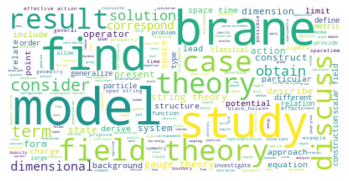

['note',
 'base',
 'lecture',
 'theory',
 'dimension',
 'point',
 'view',
 'superstre',
 'case',
 'type',
 'type',
 'iib',
 'string',
 'compactifie',
 'heterotic',
 'string',
 'compactifie',
 'consider',
 'detail',
 'pay',
 'specific',
 'attention',
 'difference',
 'theory',
 'space',
 'vector',
 'space',
 'hypermultiplet',
 'review',
 'case',
 'hypermultiplet',
 'review',
 'limit',
 'poor',
 'state',
 'current',
 'understanding',
 'peculiaritie',
 'mixed',
 'instanton',
 'discuss']

In [8]:
df = pd.DataFrame(tmp, columns =['abstract'])
physics_cleaned = clean_data(df, 'abstract')
# physics_cleaned = physics_cleaned[:500]
physics_prepared = prepare_data(physics_cleaned.values)
physics_prepared[0]

### BBC business

In [9]:
df_bbc = pd.read_csv('drive/MyDrive/Colab Notebooks/datasets/articles_bbc/business.csv')
df_bbc

,text
0,Ad sales boost Time Warner profit\n\nQuarterly...
1,Dollar gains on Greenspan speech\n\nThe dollar...
2,Yukos unit buyer faces loan claim\n\nThe owner...
3,High fuel prices hit BA's profits\n\nBritish A...
4,Pernod takeover talk lifts Domecq\n\nShares in...
...,...
505,Trial begins of Spain's top banker\n\nThe tria...
506,UK economy ends year with spurt\n\nThe UK econ...
507,HealthSouth ex-boss goes on trial\n\nThe forme...
508,Euro firms miss out on optimism\n\nMore than 9...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: FutureWarning: The default value of regex will change from True to False in a future version.


Povodny text po tokenizacii, pocet slov:
160366
['ad', 'sales', 'boost', 'time', 'warner', 'profit', 'quarterly', 'profits', 'at', 'us', 'media', 'giant', 'timewarner', 'jumped', 'to', 'bn', 'for', 'the', 'three', 'months', 'to', 'december', 'from', 'year', 'earlier', 'the', 'firm', 'which', 'is', 'now', 'one', 'of', 'the', 'biggest', 'investors', 'in', 'google', 'benefited', 'from', 'sales', 'of', 'high', 'speed', 'internet', 'connections', 'and', 'higher', 'advert', 'sales', 'timewarner']
Pocet slov po vymazani dvojpismenkovych a menej slov:
62396
151
['sale', 'boost', 'profit', 'profit', 'media', 'giant', 'jump', 'month', 'year', 'earlier', 'firm', 'big', 'investor', 'benefit', 'sale', 'high', 'speed', 'internet', 'connection', 'high', 'advert', 'sale', 'fourth_quarter', 'sale', 'rise', 'profit', 'buoy', 'gain', 'offset', 'profit', 'search', 'engine', 'mixed', 'fortune', 'lose', 'subscriber', 'fourth_quarter', 'profit', 'lower', 'precede', 'quarter', 'company', 'underlie', 'profit',

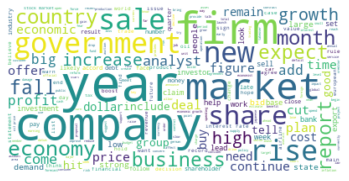

['sale',
 'boost',
 'profit',
 'profit',
 'media',
 'giant',
 'jump',
 'month',
 'year',
 'earlier',
 'firm',
 'big',
 'investor',
 'benefit',
 'sale',
 'high',
 'speed',
 'internet',
 'connection',
 'high',
 'advert',
 'sale',
 'fourth_quarter',
 'sale',
 'rise',
 'profit',
 'buoy',
 'gain',
 'offset',
 'profit',
 'search',
 'engine',
 'mixed',
 'fortune',
 'lose',
 'subscriber',
 'fourth_quarter',
 'profit',
 'lower',
 'precede',
 'quarter',
 'company',
 'underlie',
 'profit',
 'exceptional',
 'item',
 'rise',
 'strong',
 'internet',
 'advertising',
 'revenue',
 'hope',
 'increase',
 'subscriber',
 'offer',
 'online',
 'service',
 'free',
 'internet',
 'customer',
 'try',
 'sign',
 'exist',
 'customer',
 'high',
 'speed',
 'broadband',
 'timewarner',
 'restate',
 'result',
 'follow',
 'quarter',
 'profit',
 'slightly',
 'analyst',
 'expectation',
 'film',
 'division',
 'profit',
 'slump',
 'help',
 'box',
 'office',
 'flop',
 'year',
 'earlier',
 'final',
 'film',
 'ring',
 'boost',


In [10]:
bbc_cleaned = clean_data(df_bbc, "text")
bbc_prepared = prepare_data(bbc_cleaned.values)
bbc_prepared[0]

### Biologia

In [11]:
df_bio = pd.read_csv('drive/MyDrive/Colab Notebooks/datasets/biology.txt', sep=';', header=None, names=["id", "med", "Aut", "title", "cit", "type", "genes", "abstract"])
df_bio

,id,med,Aut,title,cit,type,genes,abstract
0,3,NaN,"Abdulkader N,Brun JL","Induction, detection and isolation of temperat...",Revue de Nematologie 1: 27-37 1978,ARTICLE,NaN,Applying a series of techniques intended to in...
1,5,NaN,"Abi-Rached M,Brun JL",Etude ultrastructurale des relations entre ovo...,Nematologica 21: 151-162 1975,ARTICLE,NaN,"Before diakinesis, the development of the oocy..."
2,6,NaN,"Abi-Rached M,Brun JL",Ultrastructural changes in the nuclear and per...,Revue de Nematologie 1: 63-72 1978,ARTICLE,NaN,Electron microscope studies in and around the ...
3,7,NaN,"Abi-Rached M,Brun JL",Changes in the synaptonemal complex in the ooc...,C.R. des Seances de l'Academie des Sciences Se...,ARTICLE,NaN,During oogenesis in the hermaphroditic nematod...
4,8,78127686.0,"Albertson DG,Sulston JE,White JG",Cell cycling and DNA replication in a mutant b...,Developmental Biology 63: 165-178 1978,ARTICLE,lin-5 nuc-1,The postembryonic development of the nematode ...
...,...,...,...,...,...,...,...,...
3226,3323,99069142.0,"Kuwabara PE,Okkema PG,Kimble J",Germ-line regulation of the Caenorhabditis ele...,Developmental Biology 204: 251-262 1998,ARTICLE,fem-1 fem-3 fog-2 mor-2 tra-2,The Caenorhabditis elegans sex-determining gen...
3227,3324,99069143.0,"Williams-Masson EM,Heid PJ,Lavin CA,Hardin J",The cellular mechanism of epithelial rearrange...,Developmental Biology 204: 263-276 1998,ARTICLE,die-1,The mechanism by which epithelial cells rearra...
3228,3325,98453399.0,"Schumacher JM,Ashcroft N,Donovan PJ,Golden A","A highly conserved centrosomal kinaase, AIR-1,...",Development 125: 4391-4402 1998,ARTICLE,air-1 air-2 pie-1,"S. cerevisiae Ipl1, Drosophila Aurora, and the..."
3229,3326,99092382.0,"Fujita M,Kawano T,Terashima K,Tanaka Y,Sakamoto H",Expression of spliceosome-associated protein 4...,Biochemical and Biophysical Research Communica...,ARTICLE,mom-2,Spliceosome-associated protein 49 (SAP 49) is ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: FutureWarning: The default value of regex will change from True to False in a future version.


Povodny text po tokenizacii, pocet slov:
468027
['applying', 'series', 'of', 'techniques', 'intended', 'to', 'induce', 'detect', 'and', 'isolate', 'lethal', 'and', 'or', 'sterile', 'temperature', 'sensitive', 'mutants', 'specific', 'to', 'the', 'self', 'fertilizing', 'hermaphrodite', 'nematode', 'caenorhabditis', 'elegans', 'bergerac', 'strain', 'such', 'mutants', 'have', 'been', 'found', 'optimal', 'conditions', 'for', 'the', 'application', 'of', 'mutagenic', 'treatment', 'and', 'the', 'detection', 'of', 'such', 'mutations', 'are', 'discussed']
Pocet slov po vymazani dvojpismenkovych a menej slov:
210676
25
['apply', 'series', 'technique', 'intend', 'induce', 'detect', 'isolate', 'lethal', 'sterile', 'temperature_sensitive', 'mutant', 'specific', 'self_fertilize', 'bergerac', 'strain', 'mutant', 'find', 'optimal', 'condition', 'application', 'mutagenic', 'treatment', 'detection', 'mutation', 'discuss']


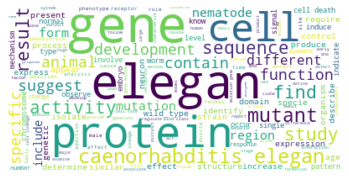

['apply',
 'series',
 'technique',
 'intend',
 'induce',
 'detect',
 'isolate',
 'lethal',
 'sterile',
 'temperature_sensitive',
 'mutant',
 'specific',
 'self_fertilize',
 'bergerac',
 'strain',
 'mutant',
 'find',
 'optimal',
 'condition',
 'application',
 'mutagenic',
 'treatment',
 'detection',
 'mutation',
 'discuss']

In [12]:
bio_cleaned = clean_data(df_bio, "abstract")
# bio_cleaned = bio_cleaned[:500]
bio_prepared = prepare_data(bio_cleaned.values)
bio_prepared[0]

### NIPS

In [13]:
df_nips = pd.read_csv('drive/MyDrive/Colab Notebooks/datasets/papers.csv', nrows=7000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: FutureWarning: The default value of regex will change from True to False in a future version.


Povodny text po tokenizacii, pocet slov:
466569
['non', 'negative', 'matrix', 'factorization', 'nmf', 'has', 'previously', 'been', 'shown', 'to', 'be', 'useful', 'decomposition', 'for', 'multivariate', 'data', 'two', 'different', 'multi', 'plicative', 'algorithms', 'for', 'nmf', 'are', 'analyzed', 'they', 'differ', 'only', 'slightly', 'in', 'the', 'multiplicative', 'factor', 'used', 'in', 'the', 'update', 'rules', 'one', 'algorithm', 'can', 'be', 'shown', 'to', 'minimize', 'the', 'conventional', 'least', 'squares', 'error']
Pocet slov po vymazani dvojpismenkovych a menej slov:
240014
41
['factorization', 'nmf', 'previously', 'useful', 'decomposition', 'multivariate', 'datum', 'different', 'multi', 'plicative', 'algorithm', 'nmf', 'analyze', 'differ', 'slightly', 'multiplicative', 'factor', 'update', 'rule', 'minimize', 'conventional', 'error', 'minimize', 'generalize', 'divergence', 'monotonic', 'algorithm', 'prove', 'tion', 'analogous', 'prove', 'expectation_maximization', 'interpret'

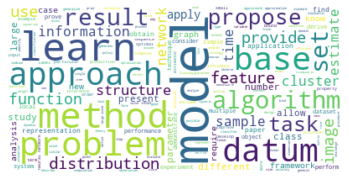

['factorization',
 'nmf',
 'previously',
 'useful',
 'decomposition',
 'multivariate',
 'datum',
 'different',
 'multi',
 'plicative',
 'algorithm',
 'nmf',
 'analyze',
 'differ',
 'slightly',
 'multiplicative',
 'factor',
 'update',
 'rule',
 'minimize',
 'conventional',
 'error',
 'minimize',
 'generalize',
 'divergence',
 'monotonic',
 'algorithm',
 'prove',
 'tion',
 'analogous',
 'prove',
 'expectation_maximization',
 'interpret',
 'onally',
 'rescale',
 'gradient_descent',
 'factor',
 'optimally',
 'choose',
 'ensure',
 'convergence']

In [14]:
nips_cleaned = clean_data(df_nips, "abstract")
# nips_cleaned = nips_cleaned[:500]
nips_prepared = prepare_data(nips_cleaned.values)
nips_prepared[0]

### Covid

In [15]:
df_covid = pd.read_csv('drive/MyDrive/Colab Notebooks/datasets/covid.csv', nrows=3000)
df_covid

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,ikaekka7,432bff7a22efb0fd2d87b162ce6da91120d28cfe,PMC,Impact of influenza vaccine on childhood otiti...,10.1371/journal.pone.0190507,PMC5755876,29304178,cc-by,PURPOSE: Acute otitis media (AOM) is a common ...,2018-01-05,"Wu, Pei-Wen; Huang, Chien-Chia; Chao, Wei-Chie...",PLoS One,NaN,NaN,NaN,document_parses/pdf_json/432bff7a22efb0fd2d87b...,document_parses/pmc_json/PMC5755876.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2996,n55xvwkf,7d2d4ad7dedaa66a5e699e2986e30f9db2df4b8e,PMC,GM-CSF overexpression after influenza a virus ...,10.1186/s12931-017-0708-5,PMC5756339,29304863,cc-by,BACKGROUND: Influenza A viruses cause life-thr...,2018-01-05,"Halstead, E. Scott; Umstead, Todd M.; Davies, ...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/7d2d4ad7dedaa66a5e699...,document_parses/pmc_json/PMC5756339.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2997,ge79iq2c,778e39cb165c72b4245262781d804c4e1f6da3d7,PMC,Role of microRNAs in doxorubicin-induced cardi...,10.1007/s10741-017-9653-0,PMC5756562,28944400,cc-by,Cardiotoxicity is a well-known side effect of ...,2017-09-25,"Ruggeri, Clarissa; Gioffré, Sonia; Achilli, Fe...",Heart Fail Rev,NaN,NaN,NaN,document_parses/pdf_json/778e39cb165c72b424526...,document_parses/pmc_json/PMC5756562.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2998,bjb38t6o,2392e0e02b81ed3565b792e9794d50994acc8535,PMC,Inhibiting the Ins and Outs of HIV Replication...,10.3389/fimmu.2017.01853,PMC5758531,29354117,cc-by,"Like all viruses, human immunodeficiency virus...",2018-01-04,"Foster, Toshana L.; Pickering, Suzanne; Neil, ...",Front Immunol,NaN,NaN,NaN,document_parses/pdf_json/239

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: FutureWarning: The default value of regex will change from True to False in a future version.


Povodny text po tokenizacii, pocet slov:
612476
['objective', 'this', 'retrospective', 'chart', 'review', 'describes', 'the', 'epidemiology', 'and', 'clinical', 'features', 'of', 'patients', 'with', 'culture', 'proven', 'mycoplasma', 'pneumoniae', 'infections', 'at', 'king', 'abdulaziz', 'university', 'hospital', 'jeddah', 'saudi', 'arabia', 'methods', 'patients', 'with', 'positive', 'pneumoniae', 'cultures', 'from', 'respiratory', 'specimens', 'from', 'january', 'through', 'december', 'were', 'identified', 'through', 'the', 'microbiology', 'records', 'charts', 'of', 'patients', 'were']
Pocet slov po vymazani dvojpismenkovych a menej slov:
289246
100
['objective', 'describe', 'epidemiology', 'clinical', 'feature', 'patient', 'culture', 'prove', 'mycoplasma', 'infection', 'hospital', 'method', 'patient', 'positive', 'pneumoniae', 'culture', 'respiratory', 'specimen', 'identify', 'microbiology', 'record', 'chart', 'patient', 'review', 'result', 'patient', 'identify', 'require', 'admissio

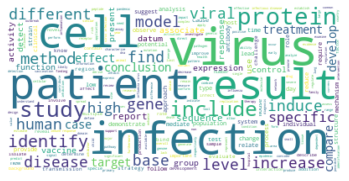

['objective',
 'describe',
 'epidemiology',
 'clinical',
 'feature',
 'patient',
 'culture',
 'prove',
 'mycoplasma',
 'infection',
 'hospital',
 'method',
 'patient',
 'positive',
 'pneumoniae',
 'culture',
 'respiratory',
 'specimen',
 'identify',
 'microbiology',
 'record',
 'chart',
 'patient',
 'review',
 'result',
 'patient',
 'identify',
 'require',
 'admission',
 'infection',
 'community_acquire',
 'infection',
 'affect',
 'age',
 'group',
 'common',
 'infant',
 'pre',
 'school',
 'child',
 'occur',
 'year',
 'round',
 'common',
 'fall',
 'spring',
 'quarter',
 'patient',
 'comorbiditie',
 'isolate',
 'tract',
 'infection',
 'bronchiolitis',
 'cough',
 'fever',
 'common',
 'symptom',
 'crepitation',
 'wheeze',
 'common',
 'sign',
 'patient',
 'crepitation',
 'bronchial',
 'breathing',
 'patient',
 'likely',
 'non',
 'patient',
 'present',
 'uneventful',
 'recover',
 'follow',
 'complication',
 'die',
 'pneumoniae',
 'infection',
 'die',
 'underlying',
 'comorbiditie',
 'patient

In [16]:
covid_cleaned = clean_data(df_covid, "abstract")
# covid_cleaned = covid_cleaned[:500]
covid_prepared = prepare_data(covid_cleaned.values)
covid_prepared[0]

### Vino

In [17]:
df_wine = pd.read_csv('drive/MyDrive/Colab Notebooks/datasets/wine.csv', nrows=3000)
df_wine

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude
...,...,...,...,...,...,...,...,...,...,...,...
2995,2995,Italy,"Dark and dense, this opens with aromas of ripe...",Marun,89,NaN,Piedmont,Barbera d'Alba Superiore,NaN,Barbera,Matteo Correggia
2996,2996,US,"Nicely textural, this propels its black-cherry...",Omero Vineyard,89,48.0,Oregon,Ribbon Ridge,Willamette Valley,Pinot Noir,Omero
2997,2997,Spain,Charcoal aromas shadow standard black fruit sc...,NaN,89,73.0,Northern Spain,Ribera del Duero,NaN,Tempranillo,Oráculo
2998,2998,US,This single-vineyard cuvée brings bold red fru...,De Ponte Vineyard,89,45.0,Oregon,Dundee Hills,Willamette Valley,Pinot Noir,Panther Creek


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: FutureWarning: The default value of regex will change from True to False in a future version.


Povodny text po tokenizacii, pocet slov:
122024
['this', 'tremendous', 'varietal', 'wine', 'hails', 'from', 'oakville', 'and', 'was', 'aged', 'over', 'three', 'years', 'in', 'oak', 'juicy', 'red', 'cherry', 'fruit', 'and', 'compelling', 'hint', 'of', 'caramel', 'greet', 'the', 'palate', 'framed', 'by', 'elegant', 'fine', 'tannins', 'and', 'subtle', 'minty', 'tone', 'in', 'the', 'background', 'balanced', 'and', 'rewarding', 'from', 'start', 'to', 'finish', 'it', 'has', 'years', 'ahead']
Pocet slov po vymazani dvojpismenkovych a menej slov:
56421
22
['tremendous', 'varietal', 'wine', 'hail', 'aged', 'year', 'compel', 'frame', 'elegant', 'fine', 'subtle', 'minty', 'tone', 'background', 'balance', 'rewarding', 'start', 'finish', 'year', 'ahead', 'develop', 'enjoy']


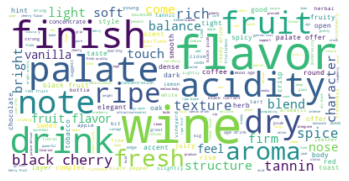

['tremendous',
 'varietal',
 'wine',
 'hail',
 'aged',
 'year',
 'compel',
 'frame',
 'elegant',
 'fine',
 'subtle',
 'minty',
 'tone',
 'background',
 'balance',
 'rewarding',
 'start',
 'finish',
 'year',
 'ahead',
 'develop',
 'enjoy']

In [18]:
wine_cleaned = clean_data(df_wine, "description")
# covid_cleaned = covid_cleaned[:500]
wine_prepared = prepare_data(wine_cleaned.values)
wine_prepared[0]

### Dlzky

In [19]:
len(nips_prepared)

3243

In [20]:
len(physics_prepared)

10909

In [21]:
len(bbc_prepared)

510

In [22]:
len(bio_prepared)

3079

In [23]:
len(covid_prepared)

2873

In [24]:
len(wine_prepared)

3000

# Exp1

## Creating dictionary

In [25]:
nips_sampled = random.sample(nips_prepared, 500)
covid_sampled = random.sample(covid_prepared, 500)
physics_sampled = random.sample(physics_prepared, 500)
bio_sampled = random.sample(bio_prepared, 500)
bbc_sampled = random.sample(bbc_prepared, 500)
wine_sampled = random.sample(wine_prepared, 500)

In [26]:
# data = nips_sampled + covid_sampled + physics_sampled + bio_sampled + bbc_sampled
data = nips_prepared[:500] + covid_prepared[:500] + physics_prepared[:500] + bio_prepared[:500] + bbc_prepared[:500]
len(data)

2500

In [27]:
random.shuffle(data)

In [28]:
id2word = corpora.Dictionary(data)

In [29]:
print(len(id2word))
# id2word.filter_n_most_frequent(100)
id2word.filter_extremes()
print(len(id2word))

corpus_all = [id2word.doc2bow(text) for text in data]
corpus_train = corpus_all[:int(2*len(data)/3)]
corpus_test = corpus_all[int(2*len(data)/3):]

13549
4170


## Creating and visualising a model

In [30]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_train,
                                           id2word=id2word,
                                           num_topics=5,
                                           random_state=100,
                                           chunksize=100,
                                           passes=2)

measure_model(lda_model, corpus_test, data, id2word)

-7.605852566758378
-1.8549488052567036


In [31]:
distr = [lda_model[corpus_all[i]]for i in range(len(data))]

top_topics = [max(i,key=lambda item:item[1]) for i in distr]

df_topic_distribution = pd.DataFrame(top_topics, columns =['Topic', 'Value'])
df_topic_distribution = df_topic_distribution['Topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution['Words'] = lda_model.show_topics(num_words=10, log=False, formatted=True)
df_topic_distribution.columns = ['Topic Num', 'Num Documents', 'Words']
df_topic_distribution.drop('Topic Num', axis=1, inplace=True)
pd.set_option('max_colwidth', 400)
df_topic_distribution

,Num Documents,Words
0,603,"(0, 0.019*""virus"" + 0.013*""protein"" + 0.011*""response"" + 0.011*""patient"" + 0.010*""infection"" + 0.008*""result"" + 0.008*""disease"" + 0.008*""cell"" + 0.007*""study"" + 0.007*""level"")"
1,519,"(1, 0.026*""cell"" + 0.019*""mutant"" + 0.015*""gene"" + 0.010*""nematode"" + 0.010*""elegan"" + 0.009*""study"" + 0.008*""activity"" + 0.007*""growth"" + 0.006*""stage"" + 0.006*""structure"")"
2,514,"(2, 0.020*""model"" + 0.015*""method"" + 0.013*""datum"" + 0.011*""base"" + 0.010*""problem"" + 0.009*""learn"" + 0.008*""provide"" + 0.008*""approach"" + 0.007*""use"" + 0.007*""result"")"
3,512,"(3, 0.022*""theory"" + 0.017*""field"" + 0.013*""model"" + 0.010*""action"" + 0.010*""space"" + 0.009*""brane"" + 0.009*""term"" + 0.009*""solution"" + 0.009*""find"" + 0.008*""form"")"
4,352,"(4, 0.017*""year"" + 0.011*""firm"" + 0.009*""market"" + 0.009*""rise"" + 0.008*""company"" + 0.007*""government"" + 0.007*""sale"" + 0.007*""economy"" + 0.007*""growth"" + 0.006*""price"")"


In [32]:
lda_output = []
for i in range(len(data)):
  top_topics = lda_model.get_document_topics(corpus_all[i], minimum_probability=0.0)
  topic_vec = [top_topics[i][1] for i in range(lda_model.num_topics)]
  lda_output.append(topic_vec)

In [33]:
clusters = KMeans(n_clusters=lda_model.num_topics, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.21  0.31  0.53  0.62  0.44]
 [ 0.01 -0.05 -0.19 -0.44  0.88]]
Perc of Variance Explained: 
 [0.03 0.37]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

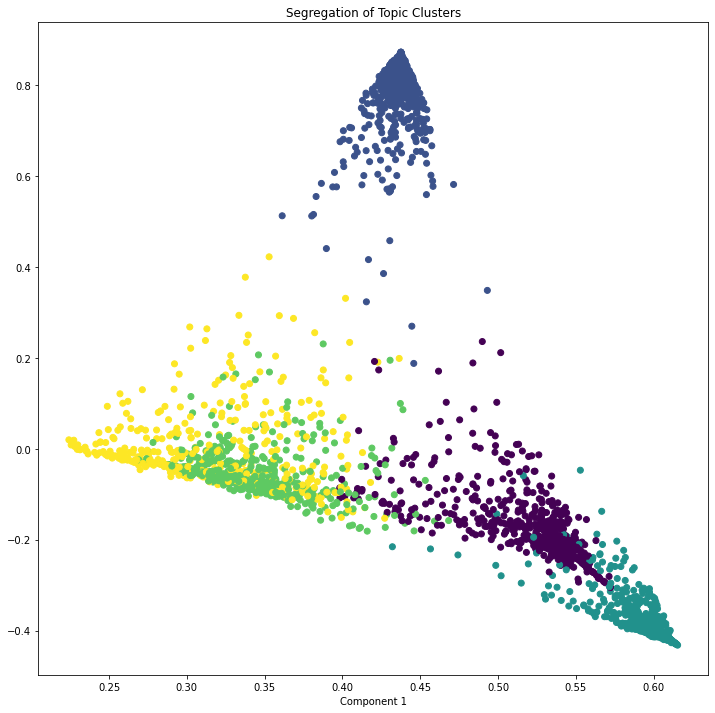

In [34]:
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [35]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus_all, id2word, sort_topics=False)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.011196 -0.207869       1        1  15.231989
1     -0.101330 -0.152694       2        1  16.068248
2     -0.110402  0.076071       3        1  22.375117
3     -0.125067  0.216075       4        1  15.187177
4      0.325604  0.068417       5        1  31.137468, topic_info=         Term         Freq        Total Category  logprob  loglift
162      cell   975.000000   975.000000  Default  30.0000  30.0000
149     model  1179.000000  1179.000000  Default  29.0000  29.0000
306    theory   589.000000   589.000000  Default  28.0000  28.0000
116    mutant   560.000000   560.000000  Default  27.0000  27.0000
380     virus   533.000000   533.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
366      rate   320.347603   536.353150   Topic5  -5.1574   0.6514
0         add   215.275721   268.425267   Topic5  -5.5549   0.9461
29       high   254.296884   567.287055   Topic5  -5.3883   0.3644
45        new   250.134992   544.566020   Topic5  -5.4048   0.3888
402  increase   227.379364   474.654992   Topic5  -5.5002   0.4308

[323 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1712      2  0.975872     abnormal
3476      2  0.975022  abnormality
2130      3  0.973381     accuracy
2130      4  0.010815     accuracy
1323      1  0.058704         acid
...     ...       ...          ...
2472      3  0.986806         word
1560      2  0.985367         worm
71        1  0.013696         year
71        2  0.001054         year
71        5  0.985043         year

[629 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

# Exp2

## Creating dictionary

In [ ]:
data = nips_prepared
len(data)

3243

In [ ]:
id2word = corpora.Dictionary(data)

In [ ]:
print(len(id2word))
id2word.filter_extremes(no_above=0.3, no_below=5)
# id2word.filter_n_most_frequent(15)
print(len(id2word))

corpus_all = [id2word.doc2bow(text) for text in data]
corpus_train = corpus_all[:int(2*len(data)/3)]
corpus_test = corpus_all[int(2*len(data)/3):]

8257
3010


In [ ]:
id2word.save_as_text("dict_text.txt") 
d = pd.read_csv('dict_text.txt', sep="\t", header=None, names=["token_id", "token_name", "token_frequency"])
d.sort_values(by=['token_frequency'], inplace=True, ascending=False)
d

,token_id,token_name,token_frequency
2454,117,set,909.0
2120,112,provide,875.0
1112,290,function,819.0
2048,109,present,791.0
1493,156,learning,776.0
...,...,...,...
1110,2126,friendly,5.0
1133,2040,generalisation,5.0
2016,2849,postulate,5.0
2805,2973,trainable,5.0


## Creating and visualising a model

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_train,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           chunksize=200,
                                           passes=2)

measure_model(lda_model, corpus_test, data, id2word)

-7.448638726347623
0.39867879829608716


In [ ]:
lda_output = []
for i in range(len(data)):
  top_topics = lda_model.get_document_topics(corpus_all[i], minimum_probability=0.0)
  topic_vec = [top_topics[i][1] for i in range(5)]
  lda_output.append(topic_vec)

In [ ]:
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.44  0.62  0.3   0.28  0.51]
 [-0.29 -0.51  0.06  0.06  0.81]]
Perc of Variance Explained: 
 [0.05 0.33]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

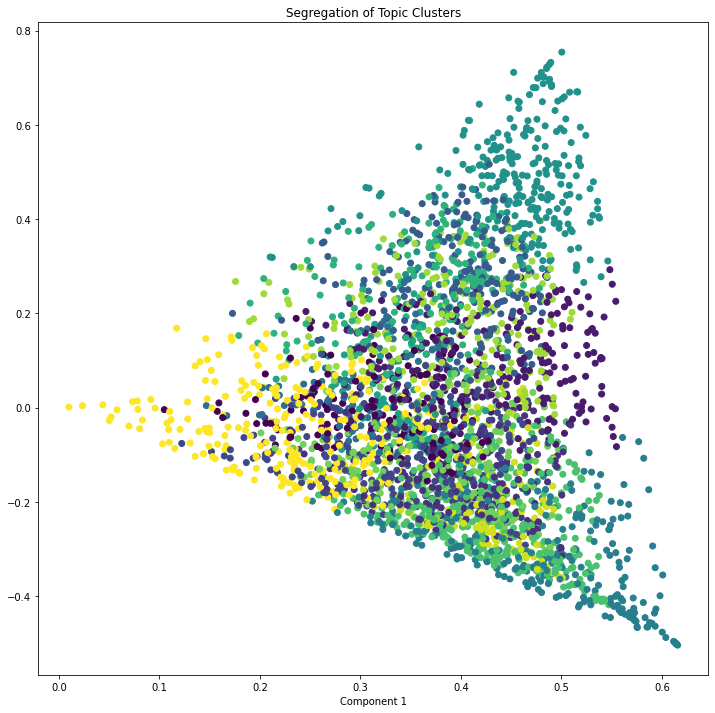

In [ ]:
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [ ]:
distr = [lda_model[corpus_all[i]]for i in range(len(data))]

top_topics = [max(i,key=lambda item:item[1]) for i in distr]

df_topic_distribution = pd.DataFrame(top_topics, columns =['Topic', 'Value'])
df_topic_distribution = df_topic_distribution['Topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution['Words'] = lda_model.show_topics(num_words=10, log=False, formatted=True)
df_topic_distribution.columns = ['Topic Num', 'Num Documents', 'Words']
df_topic_distribution.drop('Topic Num', axis=1, inplace=True)
pd.set_option('max_colwidth', 400)
df_topic_distribution

,Num Documents,Words
0,764,"(0, 0.018*""learning"" + 0.014*""function"" + 0.014*""task"" + 0.012*""policy"" + 0.010*""optimal"" + 0.009*""set"" + 0.008*""label"" + 0.008*""online"" + 0.008*""value"" + 0.008*""decision"")"
1,734,"(1, 0.011*""time"" + 0.011*""function"" + 0.009*""loss"" + 0.008*""large"" + 0.008*""gradient"" + 0.007*""stochastic"" + 0.007*""scale"" + 0.007*""set"" + 0.006*""rate"" + 0.006*""number"")"
2,548,"(2, 0.030*""network"" + 0.018*""neural"" + 0.010*""neuron"" + 0.008*""activity"" + 0.008*""dynamic"" + 0.007*""population"" + 0.007*""pattern"" + 0.007*""response"" + 0.007*""signal"" + 0.007*""stimulus"")"
3,518,"(3, 0.031*""inference"" + 0.022*""process"" + 0.018*""latent"" + 0.015*""distribution"" + 0.014*""rank"" + 0.011*""variable"" + 0.010*""mixture"" + 0.010*""probabilistic"" + 0.009*""gaussian"" + 0.009*""variational"")"
4,343,"(4, 0.024*""feature"" + 0.017*""image"" + 0.015*""cluster"" + 0.013*""object"" + 0.012*""structure"" + 0.012*""dataset"" + 0.011*""graph"" + 0.010*""tree"" + 0.009*""kernel"" + 0.008*""large"")"
5,336,"(5, 0.019*""distribution"" + 0.019*""sample"" + 0.014*""bound"" + 0.012*""low"" + 0.012*""provide"" + 0.011*""estimator"" + 0.010*""probability"" + 0.010*""function"" + 0.009*""analysis"" + 0.008*""matrix"")"


In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus_all, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.009389 -0.052038       1        1  22.565306
4      0.048733  0.001281       2        1  19.715856
0     -0.043396 -0.167995       3        1  17.041902
5     -0.222539  0.033069       4        1  15.265706
2      0.198850 -0.006157       5        1  13.845228
3      0.008962  0.191839       6        1  11.566003, topic_info=             Term         Freq        Total Category  logprob  loglift
97      inference   920.000000   920.000000  Default  30.0000  30.0000
566       network  1131.000000  1131.000000  Default  29.0000  29.0000
224       feature  1141.000000  1141.000000  Default  28.0000  28.0000
89   distribution  1060.000000  1060.000000  Default  27.0000  27.0000
378       cluster   617.000000   617.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
269         allow   121.817646   539.526888   Topic6  -5.2780   0.6689
616           non   113.863719   488.556106   Topic6  -5.3455   0.7006
126          time   129.754474  1112.894929   Topic6  -5.2149   0.0080
109       present   123.759697   917.332408   Topic6  -5.2622   0.1540
105        number   108.118532   894.688137   Topic6  -5.3973   0.0439

[458 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
653       1  0.363417  achieve
653       2  0.225176  achieve
653       3  0.220901  achieve
653       4  0.111163  achieve
653       5  0.068408  achieve
...     ...       ...      ...
172       4  0.156661     work
172       5  0.111900     work
172       6  0.049925     work
2819      1  0.017076   worker
2819      4  0.956243   worker

[1216 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 1, 6, 3, 4])

# Exp3

## Data preparation

In [ ]:
df_nips = pd.read_csv('drive/MyDrive/Colab Notebooks/datasets/papers.csv')
df_nips = df_nips[['year', 'paper_text']]
nips_grouped = [d for _, d in df_nips.groupby(['year'])]


## Creating and visualising a model

In [ ]:
def create_model(id2word, corpus_all, corpus_test, corpus_train, data):

  best_model = hypertuning(corpus_train, id2word, data)

  print("Model results")
  measure_model(best_model, corpus_test, data, id2word)


  lda_output = []
  for i in range(len(data)):
    top_topics = best_model.get_document_topics(corpus_all[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(best_model.num_topics)]
    lda_output.append(topic_vec)

  clusters = KMeans(n_clusters=best_model.num_topics, random_state=100).fit_predict(lda_output)

  # Build the Singular Value Decomposition(SVD) model
  svd_model = TruncatedSVD(n_components=2)  # 2 components
  lda_output_svd = svd_model.fit_transform(lda_output)

  # X and Y axes of the plot using SVD decomposition
  x = lda_output_svd[:, 0]
  y = lda_output_svd[:, 1]

  # Weights for the 15 columns of lda_output, for each component
  print("Component's weights: \n", np.round(svd_model.components_, 2))

  # Percentage of total information in 'lda_output' explained by the two components
  print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

  print("FIG")

  plt.figure(0, figsize=(12, 12))
  plt.scatter(x, y, c=clusters)
  plt.xlabel('Component 2')
  plt.xlabel('Component 1')
  plt.title("Segregation of Topic Clusters", )

  distr = [best_model[corpus_all[i]]for i in range(len(data))]

  top_topics = [max(i,key=lambda item:item[1]) for i in distr]

  df_topic_distribution = pd.DataFrame(top_topics, columns =['Topic', 'Value'])

  df_topic_distribution = df_topic_distribution['Topic'].value_counts().reset_index(name="Num Documents")
  df_topic_distribution['Words'] = pd.Series(best_model.show_topics(num_words=10, log=False, formatted=True))
  df_topic_distribution.columns = ['Topic Num', 'Num Documents', 'Words']
  df_topic_distribution.drop('Topic Num', axis=1, inplace=True)
  pd.set_option('max_colwidth', 400)
  
  print(df_topic_distribution)
  return best_model


In [ ]:
all_models = []
all_dictionaries = []
all_corpuses = []
for i in range(0, 30, 5):
  data = pd.concat([pd.DataFrame(d) for d in nips_grouped[i:i+5]])
  data.reset_index(inplace=True)
  data = clean_data(data, "paper_text")
  random.shuffle(data)
  data = prepare_data(data.values)
  print(len(data))
  id2word = corpora.Dictionary(data)
  print(len(id2word))
  id2word.filter_extremes(no_above=0.5, no_below=5)
  # id2word.filter_n_most_frequent(15)
  
  found_ids = []
  for ind in d.index:
    if isnan(d['token_frequency'][ind]):
      found_ids.append(d['token_id'][ind])
  if len(found_ids) > 0:
    id2word.filter_tokens(bad_ids=found_ids)

  print(len(id2word))
  corpus_all = [id2word.doc2bow(text) for text in data]
  corpus_train = corpus_all[:int(2*len(data)/3)]
  corpus_test = corpus_all[int(2*len(data)/3):]

  final_model = create_model(id2word, corpus_all, corpus_test, corpus_train, data)
  all_models.append(final_model)
  all_dictionaries.append(id2word)
  all_corpuses.append(corpus_all)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: FutureWarning: The default value of regex will change from True to False in a future version.


Povodny text po tokenizacii, pocet slov:
1473125
['adaptive', 'elastic', 'models', 'for', 'hand', 'printed', 'character', 'recognition', 'geoffrey', 'hinton', 'christopher', 'williams', 'and', 'michael', 'revow', 'department', 'of', 'computer', 'science', 'university', 'of', 'toronto', 'toronto', 'ontario', 'canada', 'la', 'abstract', 'hand', 'printed', 'digits', 'can', 'be', 'modeled', 'as', 'splines', 'that', 'are', 'governed', 'by', 'about', 'control', 'points', 'for', 'each', 'known', 'digit', 'the', 'control', 'points', 'have']
Pocet slov po vymazani dvojpismenkovych a menej slov:
630974
1285
['adaptive', 'elastic', 'model', 'hand_print', 'character', 'print', 'modeled', 'spline', 'govern', 'control', 'point', 'know', 'digit', 'control', 'point', 'prefer', 'home_location', 'deformation', 'digit', 'generate', 'control', 'point', 'away', 'home_location', 'image', 'digit', 'produce', 'place', 'gaussian', 'ink', 'generator', 'uniformly', 'spline', 'real', 'image', 'recognize', 'find',

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: FutureWarning: The default value of regex will change from True to False in a future version.


Povodny text po tokenizacii, pocet slov:
1881389
['statistical', 'modeling', 'of', 'cell', 'assemblies', 'activities', 'in', 'associative', 'cortex', 'of', 'behaving', 'monkeys', 'itay', 'gat', 'and', 'naftali', 'tishby', 'institute', 'of', 'computer', 'science', 'and', 'center', 'for', 'neural', 'computation', 'hebrew', 'university', 'jerusalem', 'israel', 'abstract', 'so', 'far', 'there', 'has', 'been', 'no', 'general', 'method', 'for', 'relating', 'extracellular', 'measured', 'activity', 'of', 'neurons', 'in', 'the', 'associative', 'cortex']
Pocet slov po vymazani dvojpismenkovych a menej slov:
794969
1081
['statistical', 'modeling', 'cell', 'assembly', 'activity', 'associative', 'cortex', 'behaving_monkey', 'itay', 'general', 'method', 'relate', 'extracellular', 'measured', 'activity', 'associative', 'underlie', 'network', 'cognitive', 'state', 'propose', 'hide', 'application', 'approach', 'temporal', 'segmentation', 'firing', 'pattern', 'cortical', 'response', 'external', 'model',

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: FutureWarning: The default value of regex will change from True to False in a future version.


Povodny text po tokenizacii, pocet slov:
2274006
['classifying', 'single', 'trial', 'eeg', 'towards', 'brain', 'computer', 'interfacing', 'benjamin', 'blankertz', 'gabriel', 'curio', 'and', 'klaus', 'robert', 'ller', 'fraunhofer', 'first', 'ida', 'kekul', 'str', 'berlin', 'germany', 'neurophysics', 'group', 'dept', 'of', 'neurology', 'klinikum', 'benjamin', 'franklin', 'freie', 'universit', 'berlin', 'hindenburgdamm', 'berlin', 'germany', 'university', 'of', 'potsdam', 'am', 'neuen', 'palais', 'potsdam', 'germany', 'abstract', 'driven', 'by', 'the', 'progress']
Pocet slov po vymazani dvojpismenkovych a menej slov:
954353
1721
['classify', 'single', 'trial', 'eeg', 'brain', 'computer', 'interface', 'drive', 'single', 'trial', 'analysis', 'eeg', 'grow', 'interest', 'brain', 'computer', 'interface', 'system', 'enable', 'human', 'subject', 'computer', 'mean', 'brain', 'signal', 'upcome', 'finger_movement', 'natural', 'keyboard', 'typing', 'condition', 'predict', 'laterality', 'respective',

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: FutureWarning: The default value of regex will change from True to False in a future version.


Povodny text po tokenizacii, pocet slov:
3539818
['attentional', 'processing', 'on', 'spike', 'based', 'vlsi', 'neural', 'network', 'yingxue', 'wang', 'rodney', 'douglas', 'and', 'shih', 'chii', 'liu', 'institute', 'of', 'university', 'of', 'zurich', 'and', 'eth', 'zurich', 'ch', 'zurich', 'switzerland', 'abstract', 'the', 'neurons', 'of', 'the', 'neocortex', 'communicate', 'by', 'asynchronous', 'events', 'called', 'action', 'potentials', 'or', 'spikes', 'however', 'for', 'simplicity', 'of', 'simulation', 'most', 'models', 'of']
Pocet slov po vymazani dvojpismenkovych a menej slov:
1502480
1280
['attentional', 'processing', 'spike', 'base', 'neocortex', 'communicate', 'asynchronous', 'event', 'action', 'potential', 'spike', 'simplicity', 'simulation', 'model', 'process', 'cortical', 'network', 'assume', 'activation', 'approximate', 'event', 'rate', 'account', 'individual', 'spike', 'obstacle', 'explore', 'detailed', 'spike', 'processing', 'network', 'reduce', 'considerably', 'recent_ye

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: FutureWarning: The default value of regex will change from True to False in a future version.


Povodny text po tokenizacii, pocet slov:
5661046
['non', 'stationary', 'dynamic', 'bayesian', 'networks', 'joshua', 'robinson', 'and', 'alexander', 'hartemink', 'department', 'of', 'computer', 'science', 'duke', 'university', 'durham', 'nc', 'abstract', 'principled', 'mechanism', 'for', 'identifying', 'conditional', 'dependencies', 'in', 'time', 'series', 'data', 'is', 'provided', 'through', 'structure', 'learning', 'of', 'dynamic', 'bayesian', 'networks', 'dbns', 'an', 'important', 'assumption', 'of', 'dbn', 'structure', 'learning', 'is', 'that', 'the', 'data']
Pocet slov po vymazani dvojpismenkovych a menej slov:
2394080
2022
['non', 'stationary', 'dynamic', 'network', 'principle', 'mechanism', 'identify', 'conditional', 'provide', 'structure', 'learn', 'dynamic', 'bayesian', 'network', 'dbns', 'important', 'assumption', 'generate', 'stationary', 'process', 'assumption', 'true', 'important', 'setting', 'paper', 'introduce', 'new', 'class', 'graphical', 'model', 'non', 'stationary', '

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(all_models[0], all_corpuses[0], all_dictionaries[0])
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.099863  0.030267       1        1  30.024075
5     -0.127335 -0.043104       2        1  16.852836
3      0.025622  0.123965       3        1  14.805704
2      0.071635 -0.131175       4        1  14.703048
4      0.185604  0.020186       5        1  14.099950
0     -0.055663 -0.000139       6        1   9.514387, topic_info=              Term         Freq        Total Category  logprob  loglift
464          image  4137.000000  4137.000000  Default  30.0000  30.0000
36            cell  4312.000000  4312.000000  Default  29.0000  29.0000
270           rule  3205.000000  3205.000000  Default  28.0000  28.0000
2013         spike  1720.000000  1720.000000  Default  27.0000  27.0000
250    recognition  2586.000000  2586.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
320      threshold   273.839860  1517.785089   Topic6  -5.7371   0.6399
9         analysis   254.280326  1452.463196   Topic6  -5.8112   0.6098
13    architecture   270.995506  2514.372763   Topic6  -5.7476   0.1247
62      connection   269.005888  2395.671493   Topic6  -5.7549   0.1657
501         object   247.830481  1958.485480   Topic6  -5.8369   0.2852

[519 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
345       1  0.259934  accuracy
345       2  0.552360  accuracy
345       3  0.063014  accuracy
345       4  0.040369  accuracy
345       5  0.016738  accuracy
...     ...       ...       ...
756       3  0.036073      word
756       4  0.014638      word
756       5  0.009410      word
756       6  0.012547      word
4022      2  0.996144    writer

[1757 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 4, 3, 5, 1])